In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np

# setup dev
device = device = torch.device("cuda")
print("device is", device)

# setup net
modelname = "vgg19"
if modelname == "resnet":
    model = torchvision.models.resnet50(pretrained=True).to(device)
elif modelname == "vgg16":
    model = torchvision.models.vgg16(pretrained=True).to(device)
elif modelname == "vgg19":
    model = torchvision.models.vgg19(pretrained=True).to(device)
else:
    raise ValueError
    
print("model is", model)

device is cuda
model is VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [2]:
%load_ext autoreload
%autoreload 1
%aimport deployment.dataloader
%aimport deployment.misc
%aimport methods.grad_cam
%aimport methods.grad_based
%aimport methods.occlusion

In [3]:
from torchvision.transforms import ToTensor, RandomCrop, CenterCrop, Resize
from deployment.dataloader import *

def transform(img):
    """ shift color axes to back """
    return np.swapaxes(np.swapaxes(img, 0, 2), 0, 1)

def prepare(img):
    img = Resize(256)(img)
    #img = RandomCrop((224,224))(img)
    img = CenterCrop((224,224))(img)
    img = ToTensor()(img)
    img = img.unsqueeze(0)
    img = img.to(device)
    return img

# setup data
filename = '../data/imagenet_full/imagenet.hdf5'
show_loader = ImageNetDataset(filename, train=False)
dct = None
with open('../data/imagenet_full/dict.txt', encoding='utf-8') as data_file:
    dct = yaml.load(data_file.read())


sturgeon


  0%|                                                                        | 0/50 [00:00<?, ?it/s]


RuntimeError: CUDA error: out of memory

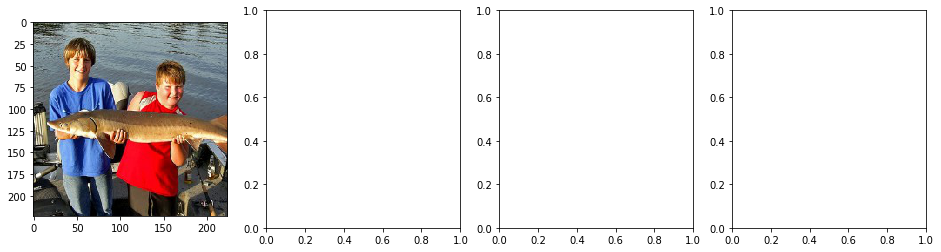

In [4]:
from methods.grad_based import *
from methods.grad_cam import *
from methods.occlusion import *
from deployment.misc import *

layer = find_layer(model.features, "35")
gc = GradCAM(model=model, device=device, layer=layer)

viz = Overlay()

methods = []
#methods.append(gc)
#methods.append(Occlusion(model=model, size=20, stride=10, patch_type="inv"))
#methods.append(Occlusion(model=model, size=20, stride=10, patch_type="color", patch_value=0.0))
#methods.append(Occlusion(model=model, size=25, stride=2, patch_type="inv"))
#methods.append(Occlusion(model=model, size=10, patch_type="inv"))
#methods.append(SmoothGrad(model=model, steps=1,std=0)) # = gradients
#methods.append(SmoothGrad(model=model, steps=30,std=0.2))
#methods.append(SmoothGrad(model=model, steps=1,std=0, cc_transform="mean")) # gradients
#methods.append(SmoothGrad(model=model, std=0, times_input=True))
#methods.append(SmoothGrad(model=model, times_input=True))
methods.append(IntegratedGradients(model=model, steps=50, mode="logits"))
methods.append(IntegratedGradients(model=model, steps=50, mode="probs"))
methods.append(IntegratedGradients(model=model, steps=50, mode="nll_loss"))
#methods.append(IntegratedGradients(model=model, steps=30, baseline=0, cc_transform="mean"))


for i, (img, real_label) in enumerate(show_loader):
    if i == 3:
        print(dct[real_label])
        img = prepare(img)
        maps = compare_methods(methods, 
                               model=model, 
                               img=img, 
                               eval_class=None, 
                               img_trafo=transform, 
                               blur=2,
                               viz=viz)
        break